In [1]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
data_dir = "/home/wubbalubba/DL/Datasets"

train_dir = data_dir + "/train"
dev_dir = data_dir + "/dev"
test_dir = data_dir + "/test"

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize(500),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

dev_transforms = transforms.Compose([
    transforms.Resize(500),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(500),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

check_transforms = transforms.Compose([
    transforms.Resize(400),
])

In [4]:
train_ds = datasets.ImageFolder(train_dir,transform=train_transforms)

#dev_ds = datasets.ImageFolder(dev_dir,transform=dev_transforms)

test_ds = datasets.ImageFolder(test_dir,transform=test_transforms)

check_ds = datasets.ImageFolder(test_dir, transform=check_transforms)

In [5]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight  

In [6]:
weights = make_weights_for_balanced_classes(train_ds.imgs, len(train_ds.classes))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
                                                                                
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=4, shuffle = False, sampler = sampler) 

/home/wubbalubba/anaconda3/lib/python3.6/site-packages/torch/utils/data/sampler.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.weights = torch.tensor(weights, dtype=torch.double)


In [7]:
from torch.utils.data import DataLoader

In [8]:
train_dl = DataLoader(train_ds, batch_size = 4, shuffle = True)

#dev_dl = DataLoader(dev_ds, batch_size = 2, shuffle = False)

test_dl = DataLoader(test_ds, batch_size = 1, shuffle = False)

check_dl = DataLoader(check_ds, batch_size = 1, shuffle = False)

In [9]:
train_iter = iter(train_dl)
X, y = next(train_iter)
print("X: {} \ny: {}".format(X.shape,y.shape))
train_dl.dataset

X: torch.Size([50, 3, 224, 224]) 
y: torch.Size([50])


Dataset ImageFolder
    Number of datapoints: 50
    Root Location: /home/wubbalubba/DL/Datasets/train
    Transforms (if any): Compose(
                             Resize(size=500, interpolation=PIL.Image.BILINEAR)
                             RandomCrop(size=(224, 224), padding=None)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [10]:
N_epochs = 10

In [11]:
model = models.resnet18(pretrained=True)

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [13]:
def all_frozen(model_params):
    return all(not p.requires_grad for p in model_params)

def all_trainable(model_params):
    return all(p.requires_grad for p in model_params)

def get_trainable(model_params):
    return (p for p in model_params if p.requires_grad)

def freeze_all(model_params):
    for param in model_params:
        param.requires_grad = False

In [14]:
freeze_all(model.parameters())
assert all_frozen(model.parameters())

In [15]:
model.fc = nn.Linear(512, 2)



In [16]:
criterion = nn.CrossEntropyLoss()

In [17]:
optimizer = torch.optim.Adam(
    get_trainable(model.parameters()),
    lr=0.001,
    # momentum=0.9,
)

In [18]:
N_EPOCHS = 30
train_loss = []
valid_loss = []
for epoch in range(N_EPOCHS):
    print(f"Epoch {epoch+1}/{N_EPOCHS}")
    
    # Train
    model.train()  # IMPORTANT
    
    running_loss, correct = 0.0, 0
    for X, y in train_dl:
        
        
        optimizer.zero_grad()
        y_ = model(X)
        loss = criterion(y_, y)
        loss.backward()
        optimizer.step()
        
        # Statistics
        #print(f"    batch loss: {loss.item():0.3f}")
        _, y_label_ = torch.max(y_, 1)
        correct += (y_label_ == y).sum().item()
        running_loss += loss.item() * X.shape[0]
    
    print(f"  Train Loss: {running_loss / len(train_dl.dataset)}")
    print(f"  Train Acc:  {correct / len(train_dl.dataset)}")
    train_loss.append([epoch,running_loss / len(train_dl.dataset)])
    
    # Eval
    model.eval()  # IMPORTANT
    
    running_loss, correct = 0.0, 0
    with torch.no_grad():  # IMPORTANT
        for X, y in test_dl:
            
                    
            y_ = model(X)
        
            # Statistics
            _, y_label_ = torch.max(y_, 1)
            correct += (y_label_ == y).sum().item()
            loss = criterion(y_, y)
            running_loss += loss.item() * X.shape[0]
    
    print(f"  Valid Loss: {running_loss / len(test_dl.dataset)}")
    print(f"  Valid Acc:  {correct / len(test_dl.dataset)}")
    valid_loss.append([epoch,running_loss / len(train_dl.dataset)])

Epoch 1/30
  Train Loss: 0.8138710856437683
  Train Acc:  0.38
  Valid Loss: 0.7664822846651077
  Valid Acc:  0.26666666666666666
Epoch 2/30
  Train Loss: 0.49564051628112793
  Train Acc:  0.8
  Valid Loss: 0.5768536359071732
  Valid Acc:  0.7333333333333333
Epoch 3/30
  Train Loss: 0.42152318358421326
  Train Acc:  0.82
  Valid Loss: 0.5191781262556712
  Valid Acc:  0.7
Epoch 4/30
  Train Loss: 0.3824525773525238
  Train Acc:  0.82
  Valid Loss: 0.5237697939078013
  Valid Acc:  0.7
Epoch 5/30
  Train Loss: 0.4346945285797119
  Train Acc:  0.82
  Valid Loss: 0.5445933779080708
  Valid Acc:  0.7
Epoch 6/30
  Train Loss: 0.49224549531936646
  Train Acc:  0.82
  Valid Loss: 0.5631237685680389
  Valid Acc:  0.7
Epoch 7/30
  Train Loss: 0.5415816903114319
  Train Acc:  0.82
  Valid Loss: 0.5637196441491444
  Valid Acc:  0.7
Epoch 8/30
  Train Loss: 0.48587116599082947
  Train Acc:  0.82
  Valid Loss: 0.5540393809477488
  Valid Acc:  0.7
Epoch 9/30
  Train Loss: 0.4748750329017639
  Train Ac

In [19]:
test_dl = DataLoader(test_ds, batch_size = len(test_ds), shuffle = False)
with torch.no_grad():# IMPORTANT
    running_loss, correct = 0.0, 0
    for X, y in test_dl:
            
            y_ = model(X)
        
            # Statistics
            _, y_label_ = torch.max(y_, 1)
            correct += (y_label_ == y).sum().item()
            loss = criterion(y_, y)
            running_loss += loss.item() * X.shape[0]
            
    F1ScoreMicro = f1_score(y, y_label_, average="micro")
    F1ScoreMacro = f1_score(y, y_label_, average="macro")
    F1ScoreWeighted = f1_score(y, y_label_, average="weighted")
    print(f"F1-score micro: {F1ScoreMicro}")
    print(f"F1-score macro: {F1ScoreMacro}")
    print(f"F1-score weighted: {F1ScoreWeighted}")
    print(f"  Valid Loss: {running_loss / len(test_dl.dataset)}")
    print(f"  Valid Acc:  {correct / len(test_dl.dataset)}")
    print(y)
    print(y_label_)

F1-score micro: 0.9
F1-score macro: 0.8666666666666667
F1-score weighted: 0.8933333333333333
  Valid Loss: 0.2598842978477478
  Valid Acc:  0.9
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])
tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1])


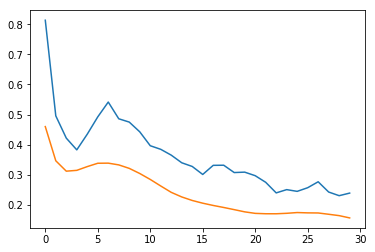

In [20]:
trl = np.asarray(train_loss)
tsl = np.asarray(valid_loss)
plt.plot(trl[:,0],trl[:,1],tsl[:,0],tsl[:,1])